In [82]:
from sqlalchemy import create_engine, text
import pandas as pd

In [83]:
def database_connect(user, password, host, port, db):
    engine = create_engine(
        f'postgresql://{user}:{password}@{host}:{port}/{db}')
    engine.connect()
    return engine

In [84]:
db_engine = database_connect('root', 'root', 'postgres-db', '5432', 'RetailDB')

In [85]:
sql = '''
    SELECT * 
    FROM online_retail_cleaned
'''
retail_cleaned_df = pd.read_sql(sql, db_engine, index_col='Id')
df_copy = retail_cleaned_df.copy()

retail_cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Id,,,,,,,,
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France


# Online Retail Sales Data Warehouse 

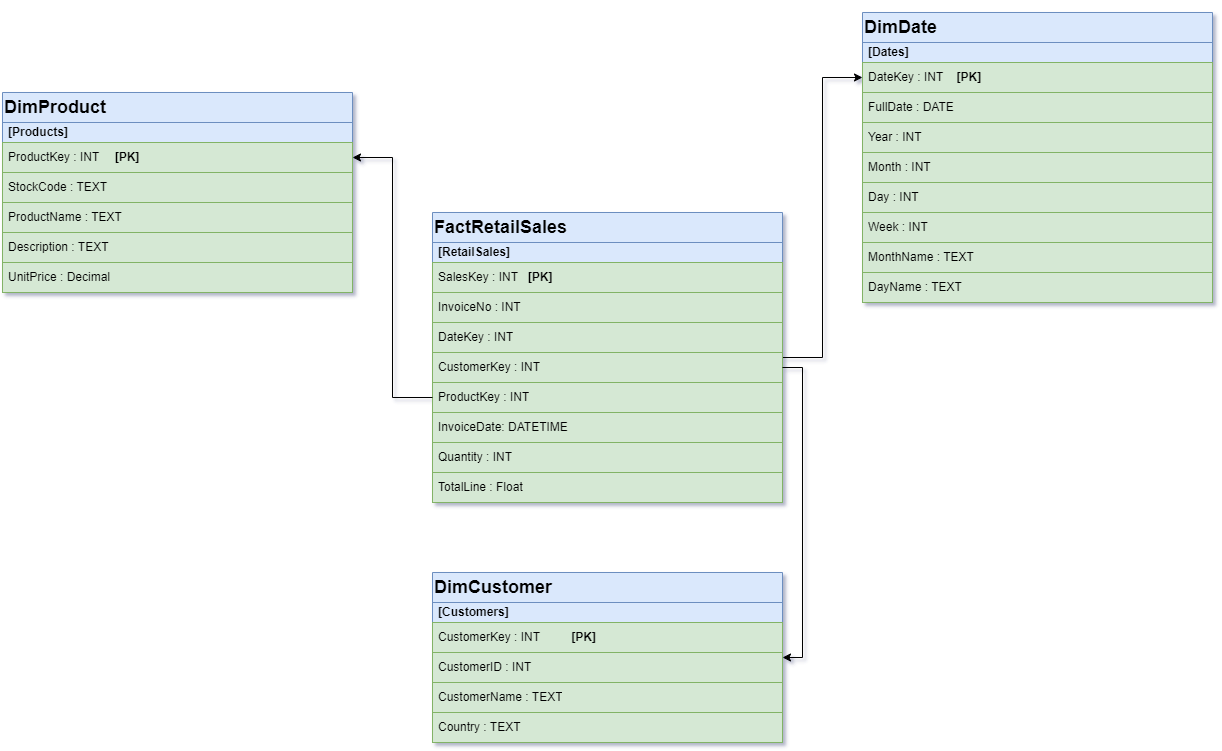

In [116]:
# Drop the fact table (if exists) to drop foreign key constraints
query = 'DROP TABLE IF EXISTS "FactRetailSales";'

with db_engine.connect() as db_conn:
    db_conn.execute(text(query))
    db_conn.commit()

## 1. `DimDate` Dimension Table

In [86]:
retail_cleaned_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [87]:
retail_cleaned_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

Build the `DimDate` table with sequence of dates from **2010-01-01** to **2012-01-01**

In [88]:
sql = '''
SELECT CAST(to_char(date_trunc('day', days)::date, 'YYYYMMDD') AS INT) AS "DateKey"
	, date_trunc('day', days):: date AS "FullDate"
	, EXTRACT(YEAR FROM days) AS "Year"
	, EXTRACT(MONTH FROM days) AS "Month"
	, EXTRACT(DAY FROM days) AS "Day"
	, EXTRACT(WEEK FROM days) AS "Week"
	, TO_CHAR(days, 'Month') AS "MonthName"
	, TO_CHAR(days, 'Day') AS "DayName"
FROM generate_series
        ( '2010-01-01'::timestamp 
        , '2012-01-01'::timestamp
        , '1 day'::interval) days;
'''
date_df = pd.read_sql(sql, db_engine, index_col='DateKey')
date_df

,FullDate,Year,Month,Day,Week,MonthName,DayName
DateKey,,,,,,,
20100101,2010-01-01,2010.0,1.0,1.0,53.0,January,Friday
20100102,2010-01-02,2010.0,1.0,2.0,53.0,January,Saturday
20100103,2010-01-03,2010.0,1.0,3.0,53.0,January,Sunday
20100104,2010-01-04,2010.0,1.0,4.0,1.0,January,Monday
20100105,2010-01-05,2010.0,1.0,5.0,1.0,January,Tuesday
...,...,...,...,...,...,...,...
20111228,2011-12-28,2011.0,12.0,28.0,52.0,December,Wednesday
20111229,2011-12-29,2011.0,12.0,29.0,52.0,December,Thursday
20111230,2011-12-30,2011.0,12.0,30.0,52.0,December,Friday


In [89]:
date_df.dtypes

FullDate      object
Year         float64
Month        float64
Day          float64
Week         float64
MonthName     object
DayName       object
dtype: object

In [90]:
date_df['Year'] = date_df['Year'].astype(int)
date_df['Month'] = date_df['Month'].astype(int)
date_df['Day'] = date_df['Day'].astype(int)
date_df['Week'] = date_df['Week'].astype(int)
date_df.dtypes

FullDate     object
Year          int64
Month         int64
Day           int64
Week          int64
MonthName    object
DayName      object
dtype: object

In [91]:
date_df.head()

,FullDate,Year,Month,Day,Week,MonthName,DayName
DateKey,,,,,,,
20100101,2010-01-01,2010,1,1,53,January,Friday
20100102,2010-01-02,2010,1,2,53,January,Saturday
20100103,2010-01-03,2010,1,3,53,January,Sunday
20100104,2010-01-04,2010,1,4,1,January,Monday
20100105,2010-01-05,2010,1,5,1,January,Tuesday


In [92]:
from time import time 

In [98]:
t_start = time()
date_df.to_sql(name='DimDate', con=db_engine, if_exists='replace', index=True, index_label='DateKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 0.0812s


In [99]:
query = 'ALTER TABLE "DimDate" ADD PRIMARY KEY ("DateKey");'
with db_engine.connect() as db_conn:
    db_conn.execute(text(query))
    db_conn.commit()

## 2. `DimCustomer` Dimension Table

In [100]:
customer_df = retail_cleaned_df[['CustomerID', 'Country']].drop_duplicates().copy()
customer_df = customer_df.reset_index(drop=True)
customer_df['CustomerKey'] = customer_df.index
# customer_df.index.names = ['CustomerKey']
customer_df.head()

,CustomerID,Country,CustomerKey
0,17850,United Kingdom,0
1,13047,United Kingdom,1
2,12583,France,2
3,13748,United Kingdom,3
4,15100,United Kingdom,4


In [101]:
def set_customer_name(customer_key): 
    return 'Customer ' + str(customer_key)
customer_df['CustomerName'] = customer_df['CustomerKey'].apply(set_customer_name)
customer_df.head()

,CustomerID,Country,CustomerKey,CustomerName
0,17850,United Kingdom,0,Customer 0
1,13047,United Kingdom,1,Customer 1
2,12583,France,2,Customer 2
3,13748,United Kingdom,3,Customer 3
4,15100,United Kingdom,4,Customer 4


In [102]:
customer_df = customer_df.set_index('CustomerKey')
customer_df.head()

,CustomerID,Country,CustomerName
CustomerKey,,,
0,17850,United Kingdom,Customer 0
1,13047,United Kingdom,Customer 1
2,12583,France,Customer 2
3,13748,United Kingdom,Customer 3
4,15100,United Kingdom,Customer 4


In [103]:
t_start = time()
customer_df.to_sql(name='DimCustomer', con=db_engine, if_exists='replace', index=True, index_label='CustomerKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 0.132s


In [104]:
query = 'ALTER TABLE "DimCustomer" ADD PRIMARY KEY ("CustomerKey");'
with db_engine.connect() as db_conn:
    db_conn.execute(text(query))
    db_conn.commit()

## 3. `DimProduct` Dimension Table

In [105]:
product_df = retail_cleaned_df[['StockCode', 'Description', 'UnitPrice']].drop_duplicates().copy()
product_df = product_df.reset_index(drop=True)
product_df['ProductKey'] = product_df.index
product_df.head()

,StockCode,Description,UnitPrice,ProductKey
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,0
1,71053,WHITE METAL LANTERN,3.39,1
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,2
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,3
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,4


In [106]:
def set_product_name(product_key): 
    return 'Product ' + str(product_key)
product_df['ProductName'] = product_df['ProductKey'].apply(set_product_name)
product_df.head()

,StockCode,Description,UnitPrice,ProductKey,ProductName
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,0,Product 0
1,71053,WHITE METAL LANTERN,3.39,1,Product 1
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,2,Product 2
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,3,Product 3
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,4,Product 4


In [107]:
product_df = product_df.set_index('ProductKey')
product_df.head()

,StockCode,Description,UnitPrice,ProductName
ProductKey,,,,
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,Product 0
1,71053,WHITE METAL LANTERN,3.39,Product 1
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,Product 2
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,Product 3
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,Product 4


In [108]:
t_start = time()
product_df.to_sql(name='DimProduct', con=db_engine, if_exists='replace', index=True, index_label='ProductKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 0.294s


In [109]:
query = 'ALTER TABLE "DimProduct" ADD PRIMARY KEY ("ProductKey");'
with db_engine.connect() as db_conn:
    db_conn.execute(text(query))
    db_conn.commit()

## 4. `FactRetailSales` Fact Table

In [117]:
sql = '''
SELECT "InvoiceNo"
	, "DateKey"
	, "CustomerKey"
	, "ProductKey"
    , "InvoiceDate"
	, "Quantity"
	, ROUND(CAST("Quantity" * ret."UnitPrice" AS numeric), 2) AS "TotalLine"
FROM online_retail_cleaned AS ret
JOIN "DimDate" AS DimDate
	ON DimDate."DateKey" = CAST(to_char(date_trunc('day', ret."InvoiceDate")::date, 'YYYYMMDD') AS INT)
INNER JOIN "DimCustomer" AS DimCustomer 
	ON DimCustomer."CustomerID" = ret."CustomerID"
	AND DimCustomer."Country" = ret."Country"
INNER JOIN "DimProduct" 
	ON "DimProduct"."StockCode" = ret."StockCode"
	AND "DimProduct"."Description" = ret."Description"
	AND "DimProduct"."UnitPrice" = ret."UnitPrice"
'''
retail_sales_df = pd.read_sql(sql, db_engine)
retail_sales_df

,InvoiceNo,DateKey,CustomerKey,ProductKey,InvoiceDate,Quantity,TotalLine
0,536370,20101201,2,31,2010-12-01 08:45:00,48,40.80
1,539322,20101216,621,31,2010-12-16 19:22:00,5,4.25
2,548606,20110401,634,31,2011-04-01 11:10:00,100,85.00
3,538853,20101214,764,31,2010-12-14 13:35:00,4,3.40
4,548702,20110403,678,31,2011-04-03 11:36:00,4,3.40
...,...,...,...,...,...,...,...
401588,581179,20111207,117,7731,2011-12-07 15:43:00,1,240.00
401589,C574344,20111104,982,8432,2011-11-04 10:18:00,1,262.73
401590,C557638,20110621,407,5838,2011-06-21 16:01:00,1,545.58
401591,C551685,20110503,13,5082,2011-05-03 12:51:00,1,1000.00


In [118]:
retail_sales_df.dtypes

InvoiceNo              object
DateKey                 int64
CustomerKey             int64
ProductKey              int64
InvoiceDate    datetime64[ns]
Quantity                int64
TotalLine             float64
dtype: object

In [119]:
retail_sales_df = retail_sales_df.reset_index(drop=True)
retail_sales_df['SalesKey'] = retail_sales_df.index
retail_sales_df = retail_sales_df.set_index('SalesKey')
retail_sales_df

,InvoiceNo,DateKey,CustomerKey,ProductKey,InvoiceDate,Quantity,TotalLine
SalesKey,,,,,,,
0,536370,20101201,2,31,2010-12-01 08:45:00,48,40.80
1,539322,20101216,621,31,2010-12-16 19:22:00,5,4.25
2,548606,20110401,634,31,2011-04-01 11:10:00,100,85.00
3,538853,20101214,764,31,2010-12-14 13:35:00,4,3.40
4,548702,20110403,678,31,2011-04-03 11:36:00,4,3.40
...,...,...,...,...,...,...,...
401588,581179,20111207,117,7731,2011-12-07 15:43:00,1,240.00
401589,C574344,20111104,982,8432,2011-11-04 10:18:00,1,262.73
401590,C557638,20110621,407,5838,2011-06-21 16:01:00,1,545.58


In [120]:
t_start = time()
retail_sales_df.to_sql(name='FactRetailSales', con=db_engine, if_exists='replace', index=True, index_label='SalesKey')
print(f'Finished insertion in {time()-t_start:.3}s')

Finished insertion in 16.1s


In [121]:
query = 'ALTER TABLE "FactRetailSales" ADD PRIMARY KEY ("SalesKey");'
with db_engine.connect() as db_conn:
    db_conn.execute(text(query))
    db_conn.commit()

## Build the relationships (foreign keys)

In [122]:
queries = [
    '''
    ALTER TABLE "FactRetailSales"
    ADD CONSTRAINT FactRetailSales_DimDate_fk
    FOREIGN KEY ("DateKey")
    REFERENCES "DimDate"("DateKey")
    ON DELETE CASCADE
    ON UPDATE CASCADE
    ''', 
    '''
    ALTER TABLE "FactRetailSales"
    ADD CONSTRAINT FactRetailSales_DimCustomer_fk
    FOREIGN KEY ("CustomerKey")
    REFERENCES "DimCustomer"("CustomerKey")
    ON DELETE CASCADE
    ON UPDATE CASCADE
    ''',
    '''
    ALTER TABLE "FactRetailSales"
    ADD CONSTRAINT FactRetailSales_DimProduct_fk
    FOREIGN KEY ("ProductKey")
    REFERENCES "DimProduct"("ProductKey")
    ON DELETE CASCADE
    ON UPDATE CASCADE
    '''
]

for query in queries:   
    with db_engine.connect() as db_conn:
        db_conn.execute(text(query))
        db_conn.commit()

# Online Retail Sales Data Warehouse (Postgres Real Implmentation)
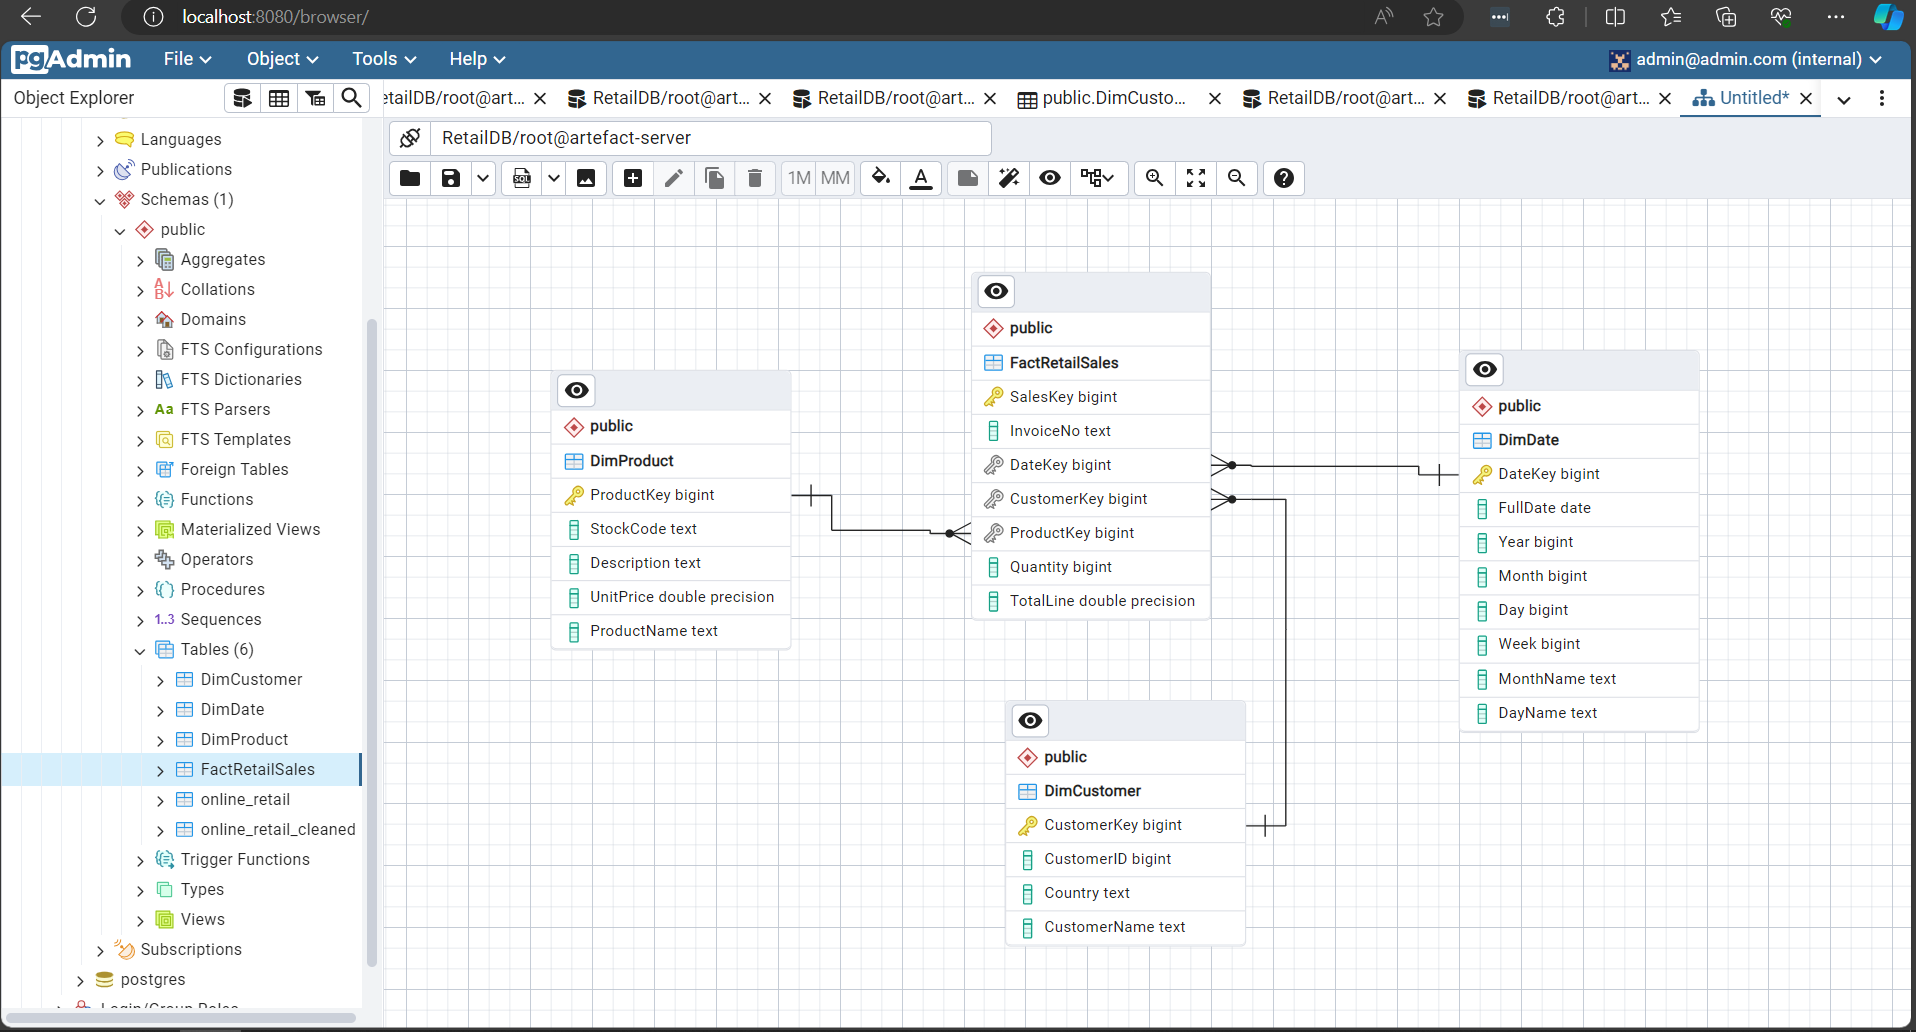